# Blood Type Evolution Model

## Import Dependencies

In [2]:
import mesa

# Data visualization tools.
import seaborn as sns

# Has multi-dimensional arrays and matrices. Has a large collection of
# mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

## Create Model and Agents

In [3]:
class HumanAgent(mesa.Agent):
    """An agent with some initial attribute values."""

    def __init__(self, model, sex, allele1, allele2, death_rates):
        # Pass the parameters to the parent class.
        super().__init__(model)

        # Create the agent's attributes and set the initial values.
        self.sex = sex
        self.genotype = [allele1, allele2]
        self.phenotype = self.determine_phenotype()
        self.death_rates = death_rates
        self.death_rate = death_rates[self.phenotype]
        self.reproduction_rate = 0.1

    def determine_phenotype(self):
        """Determine phenotype based on genotype."""
        if "A" in self.genotype and "B" in self.genotype:
            return "AB"
        elif "A" in self.genotype:
            return "A"
        elif "B" in self.genotype:
            return "B"
        else:
            return "0"

    def say_hi(self):
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        print(f"Agent ID: {str(self.unique_id)}, Sex: {str(self.sex)}, Genotype: {str(self.genotype)}")

    def die(self):
        # Agent dies with certain probability
        if self.random.random() < self.death_rate:
            self.remove()

    def reproduce(self):
        # Agent reproduces with certain probability
        if self.random.random() < self.reproduction_rate:
            
            # Filter out agents with same gender
            possible_partners = self.model.agents.select(lambda a: a.sex != self.sex)

            # Check if agents with opposing gender exist
            if len(possible_partners) > 0:
                # Randomly select agent of opposing gender
                selected_partner = self.random.choice(possible_partners)

                # Debugging: Check sex/genotype of agent and partner
                """ print(f"Own sex: {self.sex}")
                print(f"Own genotype: {self.genotype}")
                print(f"Sex of partner: {selected_partner.__getattribute__("sex")}")
                print(f"Genotype of partner: {selected_partner.__getattribute__("genotype")}") """
                
                # Create new agent with random sex and random allele from father and random allele from mother
                sex = self.random.choice(["female", "male"])
                allele1 = self.random.choice(self.genotype)
                allele2 = self.random.choice(selected_partner.genotype)
                newAgent = self.create_agents(self.model, 1, sex, allele1, allele2, self.death_rates)
                
                # Debugging: Check sex/genotype of new agent after reproduction
                """ print(f"Sex of new agent: {newAgent.get("sex")}")
                print(f"Genotype of new agent: {newAgent.get("genotype")}") """

            else:
                raise AssertionError("No reproduction possible. Only one gender present!")
        
    def mutate(self, new_allele):
        # Introduce new allele
        self.genotype[self.random.choice([0, 1])] = new_allele
        self.phenotype = self.determine_phenotype()

    def adapt_death_rate(self, death_rate):
        # Function for adapting death rate for existing agents depending on phenotype
        self.death_rate = death_rate[self.phenotype]
        if self.death_rate <= 0:
                raise AssertionError("Death rate cannot be 0!")
        if self.death_rate >= 1:
                raise AssertionError("Death rate of 1 is not plausible!")

        """ if allele in self.genotype:
            self.death_rate = self.death_rate - 0.05
            if self.death_rate < 0.01:
                self.death_rate = 0.01
            if self.death_rate <= 0:
                raise AssertionError("Death rate cannot be 0!")
        else:
            self.death_rate = self.death_rate + 0.2
            if self.death_rate >= 1:
                raise AssertionError("Death rate of 1 is not plausible!") """


    def adapt_reproduction_rate(self):
        # Function for adapting reproduction rate depending on population size
        # TODO Introduce carrying capacity to limit population growth
        """ if self.reproduction_rate > 0.05:
            self.reproduction_rate = self.reproduction_rate - self.reproduction_rate * (len(self.model.agents)/3000)
        pass """


class BloodModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, duration, initial_allele, mutation_events, death_rates, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.duration = duration
        self.mutation_events = mutation_events
        self.death_rates = death_rates

        # Collect output data
        self.datacollector = mesa.DataCollector(
            agent_reporters={"Phenotype": "phenotype", "Genotype": "genotype", "Death Rate": "death_rate", "Reproduction Rate": "reproduction_rate"}
        )

        # Create agents
        for _ in range(self.num_agents):
            a = HumanAgent(self, self.random.choice(["female", "male"]), initial_allele, initial_allele, self.death_rates)  # This calls the agent class parameter n number of times

    def step(self):
        """Advance the model by one step."""

        # This function psuedo-randomly reorders the list of agent objects and
        # then iterates through calling the function passed in as the parameter
        """ self.agents.do("say_hi") """

        # Collect data for each step
        self.datacollector.collect(self)
        
        # Introduce new alleles when reaching defined simulation duration
        # Iterate through all mutation events
        for allele, event_time_fraction in self.mutation_events.items():
            # Check if the current step matches the defined mutation event time
            if self.steps == int(event_time_fraction * self.duration):
                # Trigger the mutation for the specified allele in one random agent
                possible_agents = self.agents.select()
                selected_agent = self.random.choice(possible_agents)
                selected_agent.mutate(allele)
                # Adapt death rate for existing agents
                # TODO Change death rates of previously existing phenotypes
                self.agents.do("adapt_death_rate", self.death_rates)
                # Debugging: Check mutated agent
                print(f"Allele {allele} introduced at step {self.steps} in Agent ID: {selected_agent.unique_id}, Genotype: {selected_agent.genotype}, Phenotype: {selected_agent.phenotype}, Death Rate: {selected_agent.death_rate}")
        
        self.agents.shuffle_do("die")
        self.agents.shuffle_do("reproduce")

    # TODO Define adapt_reproduction_rate on model level
    # TODO Define adapt_death_rate on model level

## Run Model

In [4]:
# Model Parameters
number_of_agents = 10
duration = 100 # Duration of simulation in steps
initial_allele = "0" # Initial allele at start of simulation
mutation_events = {"A": 0.1, "B": 0.3} # Introduction of new alleles introduced at specific time points in simulation (Fraction of simulation time)
death_rates = {"0": 0.07, "A": 0.05, "B": 0.04, "AB": 0.02} # Dictionary of death rates depending on phenotype TODO Expand dictionary for all mutation events

model = BloodModel(number_of_agents, duration, initial_allele, mutation_events, death_rates, seed=42)
for step in range(duration):
    """ print(f"\nStep {step+1}\n")
    print(f"Number of agents: {len(model.agents)}") """
    model.step()
    
# TODO Batch run (running simulation several times)

Allele A introduced at step 10 in Agent ID: 8, Genotype: ['0', 'A'], Phenotype: A, Death Rate: 0.05
Allele B introduced at step 30 in Agent ID: 40, Genotype: ['0', 'B'], Phenotype: B, Death Rate: 0.04


## Data Analysis

        Phenotype Genotype  Death Rate  Reproduction Rate
AgentID                                                  
3               0   [0, 0]        0.07                0.1
24              0   [0, 0]        0.07                0.1
26              A   [A, 0]        0.05                0.1
29              0   [0, 0]        0.07                0.1
32              0   [0, 0]        0.07                0.1
34              A   [A, 0]        0.05                0.1
35              0   [0, 0]        0.07                0.1
36              0   [0, 0]        0.07                0.1
37              0   [0, 0]        0.07                0.1
38              0   [0, 0]        0.07                0.1
39              0   [0, 0]        0.07                0.1
40              0   [0, B]        0.07                0.1
41              0   [0, 0]        0.07                0.1


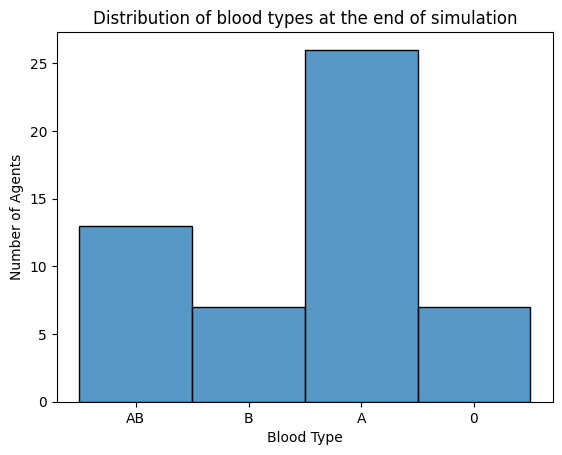

In [5]:
dataframe = model.datacollector.get_agent_vars_dataframe()
print(dataframe.loc[30]) # Get data frame for specific step in simulation
last_step = dataframe.index.get_level_values("Step").max()
end_phenotype = dataframe.xs(last_step, level="Step")["Phenotype"]
#print(end_phenotype)

# Create a histogram of bloodtype distribution at the last step
g = sns.histplot(end_phenotype, discrete=True)
g.set(
    title="Distribution of blood types at the end of simulation",
    xlabel="Blood Type",
    ylabel="Number of Agents",
);


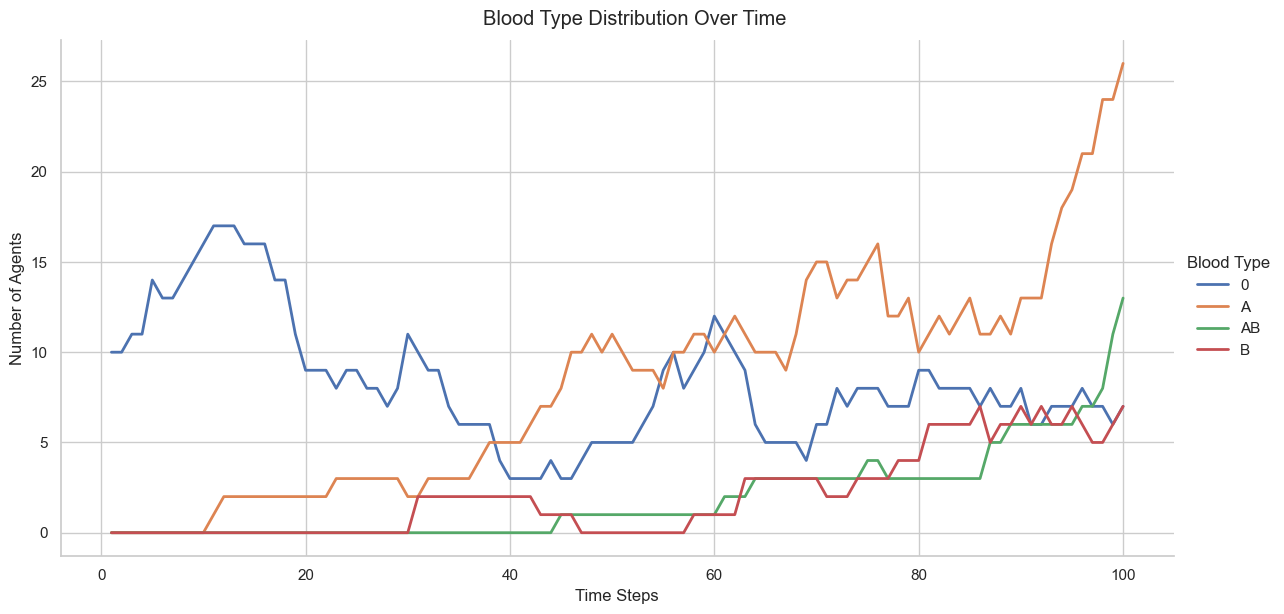

In [6]:
# Collect the data for blood type distribution over time
dataframe = model.datacollector.get_agent_vars_dataframe()

# Count occurrences of each phenotype (blood type) at each step
blood_type_over_time = dataframe.groupby(['Step', 'Phenotype']).size().unstack(fill_value=0).reset_index()

# Melt the data for Seaborn plotting
melted_data = blood_type_over_time.melt(id_vars='Step', var_name='Blood Type', value_name='Count')

# Create a Seaborn FacetGrid to manage the plot layout
sns.set_theme(style="whitegrid")
g = sns.relplot(
    data=melted_data,
    x="Step",
    y="Count",
    hue="Blood Type",
    kind="line",
    height=6,
    aspect=2,
    markers=True,
    linewidth=2
)

# Customize the plot
g.set_axis_labels("Time Steps", "Number of Agents")
g.figure.suptitle("Blood Type Distribution Over Time", y=1.02)  # Adjust title position
g.legend.set_title("Blood Type")